In [1]:
import os

base_dir = "dataset_task43"

for split in ["train", "validation"]:
    print(f"\n{split.upper()}")
    for cls in os.listdir(os.path.join(base_dir, split)):
        n = len(os.listdir(os.path.join(base_dir, split, cls)))
        print(cls, ":", n)


TRAIN
bicycle : 62
car : 61
motorcycle : 61

VALIDATION
bicycle : 17
car : 17
motorcycle : 16


In [2]:
# Cell 1 — Task 4-3: imports + basic config 
import os
import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)

DATASET_DIR = "dataset_task43"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "validation")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

# Quick sanity checks
classes = sorted(os.listdir(TRAIN_DIR))
print("Classes:", classes)
print("NUM_CLASSES:", len(classes))

TensorFlow: 2.20.0
Classes: ['bicycle', 'car', 'motorcycle']
NUM_CLASSES: 3


In [3]:
# Cell 2 — Data loaders (augmentation for train, clean val)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_generators(preprocess_fn):
    """
    Creates train/val generators for a specific model preprocessing function.
    """
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=15,
        width_shift_range=0.10,
        height_shift_range=0.10,
        zoom_range=0.15,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn
    )

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
        seed=SEED
    )

    val_gen = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen

In [4]:
# Cell 3 — Model builder (frozen vs fine-tune last N layers)
from tensorflow.keras import layers, models

def build_model(base_model, num_classes, fine_tune=False, unfreeze_last_n=20, lr=1e-3):
    """
    fine_tune=False -> frozen backbone (feature extraction)
    fine_tune=True  -> unfreeze last N layers (fine-tuning) + low LR
    """
    # Start frozen
    base_model.trainable = False

    # Unfreeze last N layers
    if fine_tune:
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    # Classification head 
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)   # keeps BatchNorm stable
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [5]:
# Cell 4 — 3 Keras Applications models
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

MODEL_SPECS = [
    {
        "name": "MobileNetV2",
        "builder": lambda: MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": mobilenet_preprocess
    },
    {
        "name": "ResNet50",
        "builder": lambda: ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": resnet_preprocess
    },
    {
        "name": "EfficientNetB0",
        "builder": lambda: EfficientNetB0(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": effnet_preprocess
    }
]

In [6]:
# Cell 5 — Train all 3 models: Frozen vs Fine-tune last 20 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd

NUM_CLASSES = len(os.listdir(TRAIN_DIR))
results_43 = []

for spec in MODEL_SPECS:
    name = spec["name"]
    print("\n" + "="*70)
    print("Task 4-3 | Model:", name)
    print("="*70)

    train_gen, val_gen = make_generators(spec["preprocess"])

    # ----- A) Frozen base -----
    print("\n--> Run A: Frozen base")
    base_A = spec["builder"]()
    model_A = build_model(base_A, NUM_CLASSES, fine_tune=False, lr=1e-3)

    callbacks_A = [
        EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.3, min_lr=1e-6)
    ]

    model_A.fit(
        train_gen,
        validation_data=val_gen,
        epochs=12,
        callbacks=callbacks_A,
        verbose=1
    )

    val_loss_A, val_acc_A = model_A.evaluate(val_gen, verbose=0)
    results_43.append({"Model": name, "Setting": "Frozen base", "Val_Accuracy": float(val_acc_A), "Val_Loss": float(val_loss_A)})

    # ----- B) Fine-tune last 20 -----
    print("\n--> Run B: Fine-tune last 20 (low LR)")
    base_B = spec["builder"]()
    model_B = build_model(base_B, NUM_CLASSES, fine_tune=True, unfreeze_last_n=20, lr=1e-5)

    callbacks_B = [
        EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.3, min_lr=1e-7)
    ]

    model_B.fit(
        train_gen,
        validation_data=val_gen,
        epochs=12,
        callbacks=callbacks_B,
        verbose=1
    )

    val_loss_B, val_acc_B = model_B.evaluate(val_gen, verbose=0)
    results_43.append({"Model": name, "Setting": "Fine-tune last 20", "Val_Accuracy": float(val_acc_B), "Val_Loss": float(val_loss_B)})

df_43 = pd.DataFrame(results_43)
df_43


Task 4-3 | Model: MobileNetV2
Found 184 images belonging to 3 classes.
Found 50 images belonging to 3 classes.

--> Run A: Frozen base
Epoch 1/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.6630 - loss: 0.7667 - val_accuracy: 1.0000 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 2/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.9457 - loss: 0.2180 - val_accuracy: 1.0000 - val_loss: 0.0758 - learning_rate: 0.0010
Epoch 3/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.9891 - loss: 0.1120 - val_accuracy: 1.0000 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 4/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.9783 - loss: 0.0983 - val_accuracy: 1.0000 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 5/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.9783 - loss: 0.0661 - val_accuracy: 1.0000 - val_loss: 0.0266 - learning_rate: 0.0010

--> Run B: Fine-tune last 20 (low LR)
Epoch 1/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 830ms/step - accuracy:

,Model,Setting,Val_Accuracy,Val_Loss
0,MobileNetV2,Frozen base,1.00,0.229597
1,MobileNetV2,Fine-tune last 20,0.96,0.359480
2,ResNet50,Frozen base,1.00,0.026134
3,ResNet50,Fine-tune last 20,1.00,0.151321
4,EfficientNetB0,Frozen base,1.00,0.180429
5,EfficientNetB0,Fine-tune last 20,0.96,0.456098


In [7]:
# Cell 6 — Results table
df_pivot_43 = df_43.pivot(index="Model", columns="Setting", values="Val_Accuracy")

df_pivot_43 = df_pivot_43.rename(columns={
    "Frozen base": "Frozen",
    "Fine-tune last 20": "Fine-tune"
})

df_pivot_43["Δ (Fine - Frozen)"] = df_pivot_43["Fine-tune"] - df_pivot_43["Frozen"]
df_pivot_43 = df_pivot_43.round(3)

df_pivot_43

Setting,Fine-tune,Frozen,Δ (Fine - Frozen)
Model,,,
EfficientNetB0,0.96,1.0,-0.04
MobileNetV2,0.96,1.0,-0.04
ResNet50,1.00,1.0,0.00


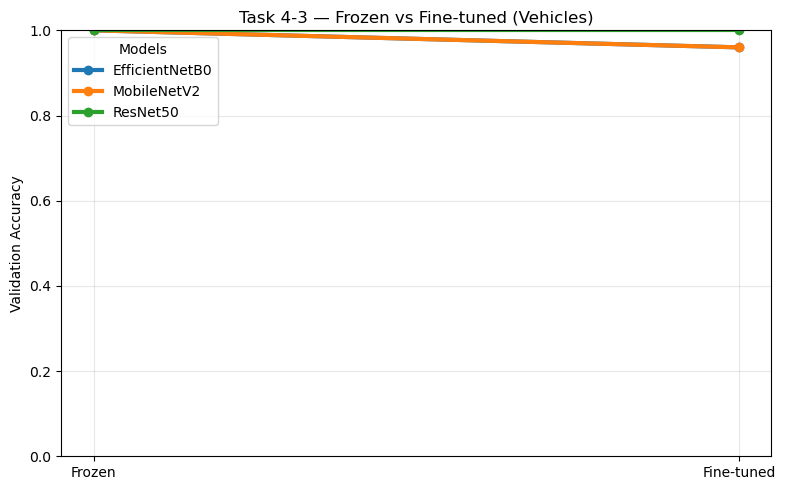

In [8]:
 # Cell 7 — Graph view: Frozen → Fine-tune 
import matplotlib.pyplot as plt

models = df_pivot_43.index.tolist()
frozen = df_pivot_43["Frozen"].values
fine   = df_pivot_43["Fine-tune"].values

plt.figure(figsize=(8,5))
for i in range(len(models)):
    plt.plot(["Frozen", "Fine-tuned"], [frozen[i], fine[i]], marker="o", linewidth=3)

plt.title("Task 4-3 — Frozen vs Fine-tuned (Vehicles)")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.legend(models, title="Models")
plt.tight_layout()
plt.show()

In [9]:
# Cell — Define build_model

import tensorflow as tf
from tensorflow.keras import layers

def build_model(base_model, num_classes, fine_tune=False, unfreeze_last_n=20, lr=1e-3):
    base_model.trainable = False

    if fine_tune:
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [10]:
# Cell — Train ONE best model (ResNet50 frozen) and save it for the REST API

import os, json
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Recreate generators for ResNet preprocessing
train_gen, val_gen = make_generators(resnet_preprocess)

# Build frozen ResNet50 model (same style you used before)
base = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3))
best_model = build_model(base, num_classes=train_gen.num_classes, fine_tune=False, lr=1e-3)

# Train briefly (you can increase epochs if you want)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
]
best_model.fit(train_gen, validation_data=val_gen, epochs=8, callbacks=callbacks, verbose=1)

# Save model
MODEL_PATH = "vehicle_resnet50_frozen.keras"
best_model.save(MODEL_PATH)
print("Saved model to:", MODEL_PATH)

# Save class names 
# Keras maps folders to indices; we invert it to list by index order
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

with open("vehicle_class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved class names:", class_names)

Found 184 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6087 - loss: 0.8716 - val_accuracy: 0.9200 - val_loss: 0.2136
Epoch 2/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9402 - loss: 0.1918 - val_accuracy: 0.9600 - val_loss: 0.1118
Epoch 3/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9837 - loss: 0.0674 - val_accuracy: 0.9800 - val_loss: 0.0646
Epoch 4/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9891 - loss: 0.0477 - val_accuracy: 0.9800 - val_loss: 0.0512
Epoch 5/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9837 - loss: 0.0628 - val_accuracy: 0.9800 - val_loss: 0.0699
Epoch 6/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 0.9800 - val_loss: 0.0449
Saved model to: vehicle_resnet50_frozen.keras
Saved class names: ['bicycle', 'car', 'motorcycle']


In [11]:
# label_image_ws.py
# Helper that loads the saved model and predicts a class for an image 

import json
import numpy as np
import tensorflow as tf
from PIL import Image
import requests
from io import BytesIO

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

MODEL_PATH = "vehicle_resnet50_frozen.keras"
CLASSES_PATH = "vehicle_class_names.json"
IMG_SIZE = (224, 224)

# Load model + class names once 
model = tf.keras.models.load_model(MODEL_PATH)

with open(CLASSES_PATH, "r") as f:
    class_names = json.load(f)


def _load_image_from_url(url: str) -> Image.Image:
    resp = requests.get(url, timeout=15)
    resp.raise_for_status()
    return Image.open(BytesIO(resp.content)).convert("RGB")


def _load_image_from_path(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")


def preprocess_pil(img: Image.Image) -> np.ndarray:
    """
    Resize -> convert to array -> add batch dimension -> apply ResNet50 preprocess_input
    """
    img = img.resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32)
    arr = np.expand_dims(arr, axis=0)  # (1, 224, 224, 3)
    arr = resnet_preprocess(arr)
    return arr


def predict_image(url: str = None, path: str = None) -> dict:
    """
    Returns:
      {"prediction": <class>, "confidence": <float>, "probs": {class: prob, ...}}
    """
    if (url is None) == (path is None):
        raise ValueError("Provide exactly one of: url OR path")

    img = _load_image_from_url(url) if url else _load_image_from_path(path)
    x = preprocess_pil(img)

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_class = class_names[pred_idx]
    confidence = float(probs[pred_idx])

    probs_dict = {class_names[i]: float(probs[i]) for i in range(len(class_names))}
    return {"prediction": pred_class, "confidence": confidence, "probs": probs_dict}

In [11]:
# webapp.py
# Flask REST API for image classification 

from flask import Flask, request, jsonify
from label_image_ws import predict_image

app = Flask(__name__)

@app.route("/health", methods=["GET"])
def health():
    return jsonify({"status": "ok"})


@app.route("/classify", methods=["POST"])
def classify():
    """
    Accepts either:
    1) JSON body: {"url": "https://..."}
    or
    2) form-data file upload with key "file"
    """
    try:
        # Case 1: JSON with URL
        if request.is_json:
            data = request.get_json()
            url = data.get("url", None)
            if not url:
                return jsonify({"error": "Missing 'url' in JSON body"}), 400

            result = predict_image(url=url)
            return jsonify(result)

        # Case 2: file upload
        if "file" in request.files:
            f = request.files["file"]
            if f.filename == "":
                return jsonify({"error": "Empty filename"}), 400

            # Save temporarily
            tmp_path = "_tmp_upload.jpg"
            f.save(tmp_path)

            result = predict_image(path=tmp_path)
            return jsonify(result)

        return jsonify({"error": "Send JSON {'url': ...} or upload a file with key 'file'"}), 400

    except Exception as e:
        return jsonify({"error": str(e)}), 500


if __name__ == "__main__":
    
    app.run(host="127.0.0.1", port=5001, debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1